In [1]:
import pandas as pd

In [2]:
fake_news = pd.read_csv('../Datasets/News/Fake.csv')
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_news = pd.read_csv('../Datasets/News/True.csv')
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake_news['label'] = 'FAKE'
true_news['label'] = 'REAL'

In [9]:
df = pd.concat([fake_news.iloc[:1000], true_news.iloc[:1000]], axis=0).reset_index(drop=True)
df.head()


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE


In [10]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017",REAL
1,Republican Senate Candidate Thinks If You Don...,Republicans always like to push back on the id...,News,"September 19, 2017",FAKE
2,Supreme Court lets Trump's latest travel ban g...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"December 4, 2017",REAL
3,Trump Spoke With Putin About Election Interfe...,"On Friday, Donald Trump finally got the chance...",News,"July 7, 2017",FAKE
4,Bill letting people bring concealed guns acros...,WASHINGTON (Reuters) - People would be able to...,politicsNews,"December 6, 2017",REAL


In [11]:
df['label'].value_counts()

label
REAL    1000
FAKE    1000
Name: count, dtype: int64

In [12]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def process_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token) > 2]
    return " ".join(tokens)

In [13]:
df['clean_text'] = df['text'].apply(process_text)

In [14]:
df.head()

,title,text,subject,date,label,clean_text
0,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017",REAL,washington reuters republican tax plan unveil ...
1,Republican Senate Candidate Thinks If You Don...,Republicans always like to push back on the id...,News,"September 19, 2017",FAKE,republicans like push idea bigot hard believe ...
2,Supreme Court lets Trump's latest travel ban g...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"December 4, 2017",REAL,washington reuters supreme court monday hand v...
3,Trump Spoke With Putin About Election Interfe...,"On Friday, Donald Trump finally got the chance...",News,"July 7, 2017",FAKE,friday donald trump finally get chance room fa...
4,Bill letting people bring concealed guns acros...,WASHINGTON (Reuters) - People would be able to...,politicsNews,"December 6, 2017",REAL,washington reuters people able bring legal con...


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

In [17]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)
X_reduced = svd.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15, metric='cosine')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=15)

              precision    recall  f1-score   support

        FAKE       0.93      0.88      0.90       200
        REAL       0.88      0.93      0.91       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



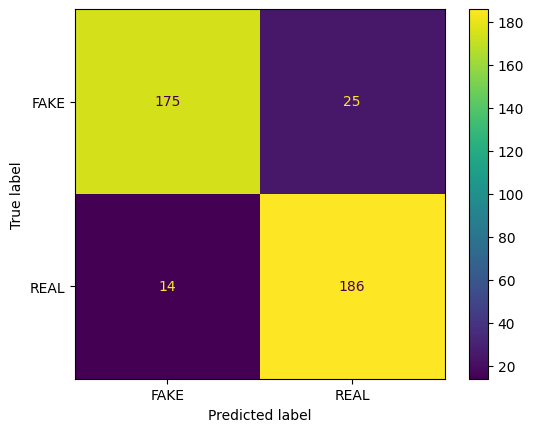

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = knn.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

ROC AUC Score: 0.9667941566177862


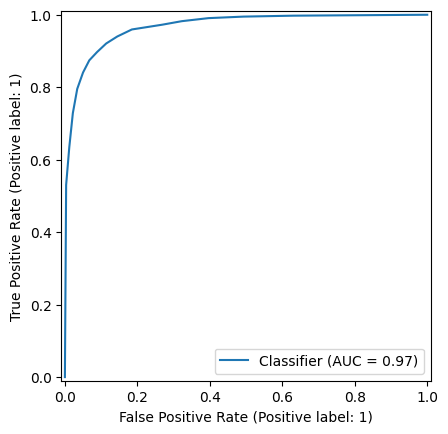

In [23]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Convert to binary
y_test_bin = y_test.map({'REAL': 1, 'FAKE': 0})
y_prob = knn.predict_proba(X_test)[:, 1]

print("ROC AUC Score:", roc_auc_score(y_test_bin, y_prob))
RocCurveDisplay.from_predictions(y_test_bin, y_prob)


In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_neighbors': [3, 5, 10, 15, 20],
    'metric': ['cosine', 'euclidean']
}

grid = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'metric': 'cosine', 'n_neighbors': 20}
